In [4]:
#Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
% matplotlib inline


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report, confusion_matrix)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

UsageError: Line magic function `%` not found.


Import Data

In [5]:
data = pd.read_csv('customers_data.csv')

In [6]:
data.head()

,Unnamed: 0,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,0,19.58,male,no,31.0,35.0,False
1,1,65.16,male,yes,23.0,61.0,False
2,2,40.60,female,no,36.0,49.0,False
3,3,38.01,male,yes,47.0,57.0,False
4,4,22.32,female,yes,5.0,39.0,False


Exploratory Data Analysis

Let us check the data types

In [7]:
data.dtypes

Unnamed: 0                 int64
purch_amt                float64
gender                    object
card_on_file              object
age                      float64
days_since_last_purch    float64
loyalty                     bool
dtype: object

Let us change the variables 'gender' and 'card_on_file' to binary to fit into model

In [8]:
data['gender'] = data['gender'].map({'male': 1, 'female': 0})


In [9]:
data['card_on_file']= data['card_on_file'].map({'yes':1, 'no':0})

Let us see if there are any missing values

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 7 columns):
Unnamed: 0               120000 non-null int64
purch_amt                120000 non-null float64
gender                   120000 non-null int64
card_on_file             120000 non-null int64
age                      120000 non-null float64
days_since_last_purch    120000 non-null float64
loyalty                  120000 non-null bool
dtypes: bool(1), float64(3), int64(3)
memory usage: 5.6 MB


There are no missing value in the dataset

In [11]:
data['loyalty'].value_counts() # data imbalance

False    100000
True      20000
Name: loyalty, dtype: int64

In [12]:
data.head()

,Unnamed: 0,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,0,19.58,1,0,31.0,35.0,False
1,1,65.16,1,1,23.0,61.0,False
2,2,40.60,0,0,36.0,49.0,False
3,3,38.01,1,1,47.0,57.0,False
4,4,22.32,0,1,5.0,39.0,False


There are no missing values in the data

Text(0.5, 1, 'Correlation map')

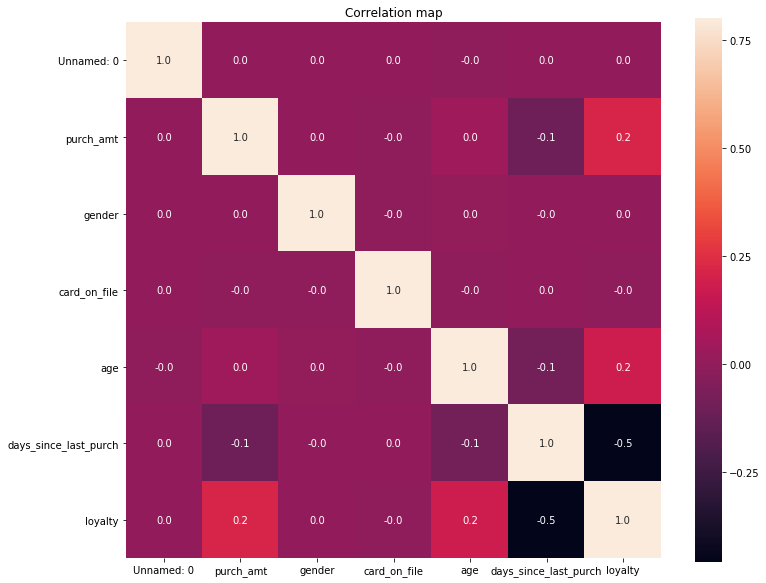

In [13]:
#Let us construct a correlation matrix to see the relationship among the variables
correlation_matrix = data.corr()
f, ax = plt.subplots(figsize= (12,10))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', vmax=.8, square=True)
plt.title('Correlation map')

The variables are not correlated to each other

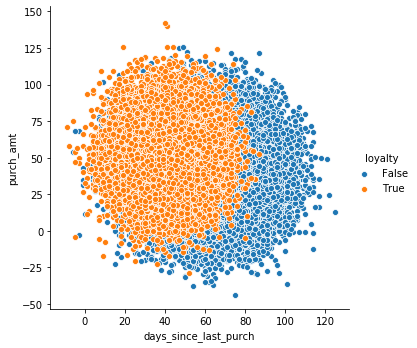

In [17]:
sns.pairplot(data=data,x_vars=['days_since_last_purch'], 
             y_vars=['purch_amt'],height=5, hue='loyalty')

We can see those who purchased since last 75 days seems more likely to have joined the loyalty program

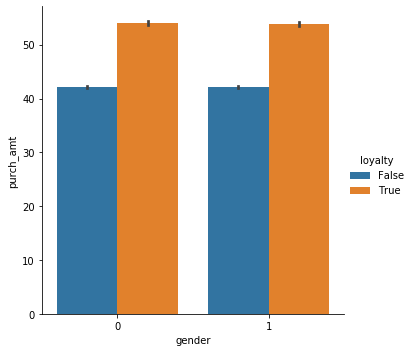

In [18]:
sns.catplot(x="gender", y="purch_amt", hue="loyalty", kind="bar", data=data);

There doesn't seem much difference being more likely to join loyalty program on the basis of purchase amount by gender.

Feature engineering 

In [19]:
features =  pd.get_dummies(data[['purch_amt', 'gender', 'card_on_file', 'age', 'days_since_last_purch']])
target = data['loyalty']

In [20]:
#Split the data to train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(90000, 5)
(30000, 5)
(90000,)
(30000,)


As we saw data imbalance in the target varaible, let us oversample the minority class (loyalty= 'True') as we are interested to know what factors contrbute to join the loyalty program. I will be using SMOTE for this

In [21]:
from imblearn.over_sampling import SMOTE
#Let us upsample the dataset
oversampler= SMOTE(random_state=0)
smote_X_train, smote_y_train = oversampler.fit_sample(X_train, y_train)

Using TensorFlow backend.


In [22]:
print(smote_X_train.shape), print(smote_y_train.shape)
print(X_test.shape), print(y_test.shape)

(149946, 5)
(149946,)
(30000, 5)
(30000,)


(None, None)

In [23]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
smote_X_train = sc.fit_transform(smote_X_train)
X_test = sc.transform(X_test)

Model Training and Evaluation

1. Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report, confusion_matrix)

In [25]:
seed = 0   # We set our random seed to zero for reproducibility
# Random Forest parameters
rf_params = {
    'n_estimators': 1000,
    'max_features': 0.3,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

#Fitting the model 
rfm = RandomForestClassifier(** rf_params)
rfm.fit(smote_X_train, smote_y_train)
rfm_predictions = rfm.predict(X_test)
print('Accuracy Score for Random Forest Model:', rfm.score(X_test, y_test))
print(classification_report(y_test, rfm_predictions)) 
Confusion_matrix = confusion_matrix(y_test, rfm_predictions)
print(Confusion_matrix)

Accuracy Score for Random Forest Model: 0.7822666666666667
              precision    recall  f1-score   support

       False       0.95      0.78      0.86     25027
        True       0.42      0.79      0.54      4973

    accuracy                           0.78     30000
   macro avg       0.68      0.78      0.70     30000
weighted avg       0.86      0.78      0.81     30000

[[19563  5464]
 [ 1068  3905]]


Feature ranking via the Random Forest

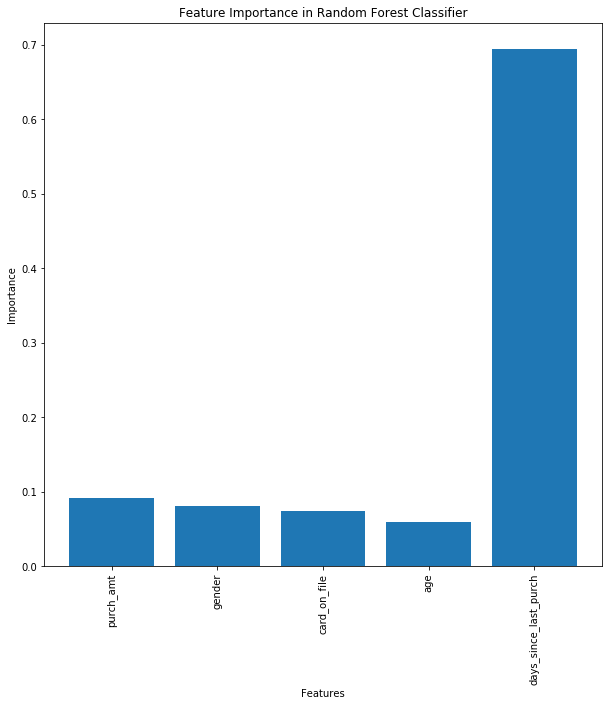

In [26]:
plt.figure(figsize=(10,10))
plt.bar(features.columns[0:30], rfm.feature_importances_[0:30])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

2. Gradient Boosting Classifier

In [27]:
gb_params ={
    'n_estimators': 1500,
    'max_features': 0.9,
    'learning_rate' : 0.25,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'subsample': 1,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

gb = GradientBoostingClassifier(**gb_params)
# Fit the model to our SMOTE train and target
gb.fit(smote_X_train, smote_y_train)
# Get our predictions
gb_predictions = gb.predict(X_test)
print('Accuracy score for Gradient Boosting Classifier:', gb.score(X_test, y_test))
print(classification_report(y_test, gb_predictions))
Confusion_matrix = confusion_matrix(y_test, gb_predictions)
print(Confusion_matrix)

Accuracy score for Gradient Boosting Classifier: 0.8612333333333333
              precision    recall  f1-score   support

       False       0.90      0.94      0.92     25027
        True       0.61      0.45      0.52      4973

    accuracy                           0.86     30000
   macro avg       0.75      0.70      0.72     30000
weighted avg       0.85      0.86      0.85     30000

[[23585  1442]
 [ 2721  2252]]


Feature ranking via Gradient Boosting classifier

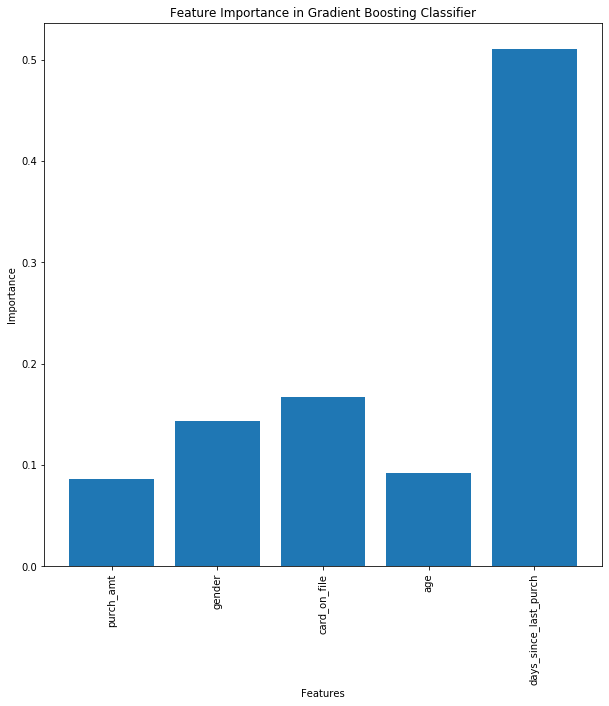

In [29]:
plt.figure(figsize=(10,10))
plt.bar(features.columns[0:30], gb.feature_importances_[0:30])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Gradient Boosting Classifier')
plt.show()

3. Logistic Regression

In [30]:
#Fitting the model
lr= LogisticRegression()
lr.fit(X_train, y_train)
lr_pred= lr.predict(X_test)
print('Accuracy Score for Logistic Regression Model:', lr.score(smote_X_train, smote_y_train))
print(classification_report(y_test, lr_pred))
Confusion_matrix = confusion_matrix(y_test, lr_pred)
print(Confusion_matrix)

C:\Users\18644\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score for Logistic Regression Model: 0.5
              precision    recall  f1-score   support

       False       0.00      0.00      0.00     25027
        True       0.17      1.00      0.28      4973

    accuracy                           0.17     30000
   macro avg       0.08      0.50      0.14     30000
weighted avg       0.03      0.17      0.05     30000

[[    0 25027]
 [    0  4973]]


C:\Users\18644\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


4. Stochastic Gradient Descent (SGD) Classifier

In [31]:
from sklearn.linear_model import SGDClassifier

sgd_params = {'alpha': 0.0001,
              'class_weight': None,
              'l1_ratio': 1,
              'loss': 'log',
              'penalty': 'elasticnet',
              'random_state': 1, 
              'shuffle': True}
sgd = SGDClassifier(**sgd_params)
sgd.fit(smote_X_train, smote_y_train)
sgd_pred = sgd.predict(X_test)
print(classification_report(y_test, sgd_pred))
Confusion_matrix = confusion_matrix(y_test, sgd.predict(X_test))
print(Confusion_matrix)

              precision    recall  f1-score   support

       False       0.95      0.80      0.87     25027
        True       0.44      0.78      0.57      4973

    accuracy                           0.80     30000
   macro avg       0.70      0.79      0.72     30000
weighted avg       0.87      0.80      0.82     30000

[[20139  4888]
 [ 1083  3890]]


Grid Search in the winning Model (Random Forest)

Random forest has the lowest type II error, though the accuracy is higher for Gradient Boosting Model. 
Since our objective is to correctly identify the customer’s propensity to join our loyalty program lesser type II error is of more importance.

In [32]:
#Grid search for RF 
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(smote_X_train, smote_y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [33]:
print('Accuracy score of Random Forest Model after Grid Search:', rf_random.score(X_test, y_test))
rf_predict = rf_random.predict(X_test)
print(classification_report(y_test, rf_predict))
Confusion_matrix = confusion_matrix(y_test, rf_predict)
print(Confusion_matrix)

Accuracy score of Random Forest Model after Grid Search: 0.8495333333333334
              precision    recall  f1-score   support

       False       0.90      0.92      0.91     25027
        True       0.55      0.49      0.52      4973

    accuracy                           0.85     30000
   macro avg       0.73      0.71      0.72     30000
weighted avg       0.84      0.85      0.85     30000

[[23028  1999]
 [ 2515  2458]]


Conclusion

I have identified a simple pipeline of prediciting customers propensity to join loyalty program from basic Exploratory Data Analysis, feature engineering and implementing four models; Random Forest Classifier, Gradient Boosting Classifier, Logistic Regression AND SGD classifier.

I also did a grid search in our winning model (Random Forest) and fitted the model which doesnt give any improved result. The feature importance diagram shows similar predictors (days_since_last_purchase, gender, card_on_file) being the major predictors for joining the loyalty program. Random forest is winning model with least Type 2 error even though overall accuracy (78%) is  lower than gradient boosting (86%) 

Next Steps
   
We can build robust NN models.
    
  